# Quantum state tomography (QST) with a neural network written in Jax

- Shahnawaz Ahmed (shahnawaz.ahmed95@gmail.com)

In this notebook we show a simple demonstration of using the custom `DensityMatrix` and `Expectation` layer to build a neural network for QST that
can take batches of data and works for an arbitrary Hilbert space dimension. We
will verify the reconstruction by using simple linear inversion and CPTP projection following the recent CPTP projection algorithm in [arXiv:2107.01060](https://arxiv.org/abs/2107.01060). We will also implement a fast iterative maximum likelihood estimation method for QST.

#### Note 1:

This notebook requires using the automatic differentiation library Jax (https://github.com/google/jax) and the DeepMind neural network tools dm-haiku (https://github.com/deepmind/dm-haiku) and optax. You also need to install QuTiP (qutip.org).

The qutip installation requires Numpy, Scipy and Matplotlib for plotting. Install these first and then install QuTiP:

```
pip install numpy scipy matplotlib
pip install qutip
```

In future notebooks I will try to reduce the dependency to only Jax and QuTiP. You can install Jax and dm-haiku simply from pip as:

```
pip install jax jaxlib
pip install dm-haiku optax
```

I also use tqdm for nice progressbars

```
pip install tqdm
```
#### Note 2:

The latest Python (3.10) has some problems building Numpy wheels while installing QuTiP. I would suggest using Python 3.9 if you face such issues or installing Numpy 1.20. as that is the one supported by QuTiP as of (Dec 1, 2021). If you have a working QuTiP installation then everything should be fine.

## Imports

In [124]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit
from jax.ops import index, index_update
from jax.config import config
from jax.experimental import optimizers

import haiku as hk

import optax


from qutip import coherent, coherent_dm, hinton, expect, Qobj
from qutip import fidelity

import matplotlib.pyplot as plt

config.update("jax_enable_x64", True) # We want float64 for better accuracy

from tqdm.auto import tqdm

# The state to be reconstructed (a CAT state)

Reconstructing the `cat` state from measurements of the Husimi Q function. The cat state is defined as:

$$|\psi_{\text{cat}} \rangle = \frac{1}{\mathcal N} ( |\alpha \rangle + |-\alpha \rangle \big ) $$

with $\alpha=2$ and normalization $\mathcal N$.

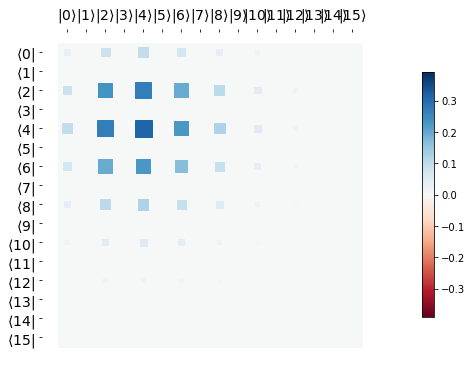

In [154]:
hilbert_size = 16
alpha = 2

psi = coherent(hilbert_size, alpha) + coherent(hilbert_size, -alpha)
psi = psi.unit() # The .unit() function normalizes the state to have unit trace

# Show the density matrix as a Hinton plot
rho_true = psi*psi.dag()

hinton(rho_true)
plt.show()

# The measurements performed on the state

We compute the operators that measure the Husimi Q function of the state. These
measurement operators can be replaced with any other operator for which we can
obtain experimental expectation values (e.g., Wigner functions, Pauli X, Y, Z for qubits etc.)

## Husimi Q function measurements

The Husimi Q function can be obtained by calculating the expectation value of measuring the following operator:

$$\mathcal O_i = \frac{1}{\pi}|\beta_i \rangle \langle \beta_i|$$

where $|\beta_i \rangle $ are coherent states written in the Fock basis.


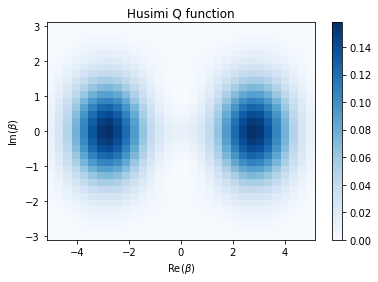

In [155]:
grid = 32

xvec = np.linspace(-5, 5, grid)
yvec = np.linspace(-3, 3, grid)

X, Y = np.meshgrid(xvec, yvec)

betas = ((X + 1j*Y)/np.sqrt(2)).ravel() # The complex-valued betas where we compute the Husimi Q

# The measurement operators
m_ops = [(1/np.pi)*coherent_dm(hilbert_size, beta) for beta in betas]
quasi_probabilities = expect(m_ops, psi)

cmap = "Blues"
im = plt.pcolor(xvec, yvec, quasi_probabilities.reshape((grid, grid)),
                vmin=0, vmax=np.max(quasi_probabilities), cmap=cmap, shading='auto')

plt.colorbar(im)

plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Husimi Q function")
plt.show()

# Data from sampling/adding Gaussian noise to the measured expectation values

In [156]:
data = quasi_probabilities + np.random.uniform(-0.005, 0.005,
                                                 size=len(quasi_probabilities))

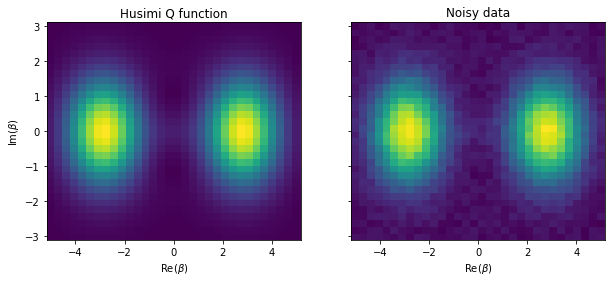

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax[0].pcolor(xvec, yvec, quasi_probabilities.reshape((grid, grid)))
ax[1].pcolor(xvec, yvec, data.reshape((grid, grid)))

ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")
ax[0].set_title("Husimi Q function")
ax[1].set_title("Noisy data")
plt.show()

# Custom expectation function compiled with Jax

In [158]:
@jit # just in time compilation for speed
def expectation(rho, ops):
    """Expectation layer that predicts the expectation value for operators

    Args:
        rho (array): A density matrix as a Jax array of shape (N, N)
        ops (array): A set of measurement operators as a Jax array of shape
                     (n, N, N) where n is the number of operators

    Returns
        evals (array): An array of expectation values for the operators.
    """
    products = jnp.einsum('nij, jk -> nik', ops, rho)
    trace = jnp.einsum('nii -> n', products)
    return trace.real


ops_jax = jnp.array([op.full() for op in m_ops])
rho_jax = jnp.array(rho_true.full())
quasi_probabilities_jax = expectation(rho_jax, ops_jax)

np.testing.assert_array_almost_equal(quasi_probabilities, quasi_probabilities_jax)

# Custom Cholesky decomposition layer that coverts a random matrix to Hermitian

In [159]:
@jit
def clean_cholesky(chi):
    """Converts a random matrix which has a shape (N, N, 2) to a Hermitian
    matrix. The last dimension contains real and imaginary parts. 
    We consider a lower triangular complex matrix with real diagonals 
    and returning T'T.

    Args:
        chi (array): A matrix of shape (N, N, 2).

    Returns
        rho (array (complex)): A Hermitian matrix using the Cholesky decomposition
    """
    diagonal_elements = jnp.diag(jnp.diag(chi).real)
    indices = jnp.tril_indices(chi.shape[0], 0)
    chi_upper = index_update(chi, index[indices], 0)
    T = chi_upper + diagonal_elements
    return jnp.conj(T.T)@T


rand_mat = np.random.random(size=(hilbert_size, hilbert_size)) + 1j*np.random.random(size=(hilbert_size, hilbert_size))
mat_cleaned = clean_cholesky(rand_mat)
print("Hermitian:", Qobj(np.array(mat_cleaned)).isherm)

Hermitian: True


# A neural network that takes noisy data and operators and outputs expectations

The network keeps a latent representation of the quantum state as a Hermitian
matrix (density matrix) which we are after.

In [160]:
class Network(hk.Module):
    """Network model that goes from data -> rho."""
    def __init__(self, hilbert_size):
        super().__init__()
        self.hilbert_size = hilbert_size

    def __call__(self, x):
        x = hk.Flatten()(x)
        x = hk.Linear(32)(x)
        x = jax.nn.leaky_relu(x)
        x = hk.Linear(32)(x)
        x = jax.nn.leaky_relu(x)
        x = hk.Linear(32)(x)
        x = jax.nn.leaky_relu(x)
        x = x.reshape(1, -1)
        x = hk.Linear(self.hilbert_size**2 * 2)(x) # Real and complex parts
        x = x.reshape(self.hilbert_size, self.hilbert_size, 2)        
        x = x[..., 0] + 1j*x[..., 1]
        x = clean_cholesky(x)
        x = x/jnp.trace(x) # Trace preserving
        return x


rng_seq = hk.PRNGSequence(32)
model_forward = hk.transform(lambda x: Network(hilbert_size=hilbert_size)(x))
model_forward = hk.without_apply_rng(model_forward)

params = model_forward.init(next(rng_seq), data)
# If you want to send data in batches this can be 
# data[:batch_size, :batch_size].real


# Writing a loss function

In [161]:
def mean_squared_error(y_pred, y):
    """
    Mean absolute error between two list of vectors
    
    Args:
        y_pred, y (ndarray): Two arrays of shape (k, n) with k different vectors each sized n.
    """
    return jnp.mean((y - y_pred)**2)


@jit
def loss_fn(params, d, ops):
    """Loss function to optimize.

    Args:
        params ([type]): Neural network parameters
        d ([type]): Data
        ops ([type]): Operators measured

    Returns:
        float: The loss value.
    """
    rho_predicted = model_forward.apply(params, d)
    data_predicted = expectation(rho_predicted, ops)
    loss = absolute_error(d, data_predicted)

    return loss + 0.001*jnp.sum(jnp.abs(rho_predicted))


print(loss_fn(params, data, ops_jax))

34.205268677566735


# Optimization with Adam

Feel free to change the hyperparameters such as the learning rate. Also the number
of optimization steps

In [162]:
optimizer = optax.adam(2e-4, 0.5, 0.5)
opt_state = optimizer.init(params)

@jax.jit
def update(
    params,
    opt_state,
    d, ops):
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, d, ops)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


loss_hist = []

100%|██████████| 1000/1000 [00:05<00:00, 192.58it/s]


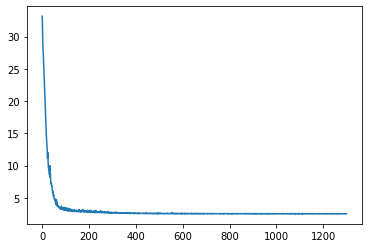

In [164]:
for step in tqdm(range(1000)):
    params, opt_state = update(params, opt_state, data, ops_jax)
    loss_hist.append(loss_fn(params, data, ops_jax))
    
plt.plot(loss_hist)

In [165]:
rho_predicted = model_forward.apply(params, data)
data_predicted = expectation(rho_predicted, ops_jax)
rho_predicted = Qobj(np.array(rho_predicted))


# Predicting the reconstruted data and the state

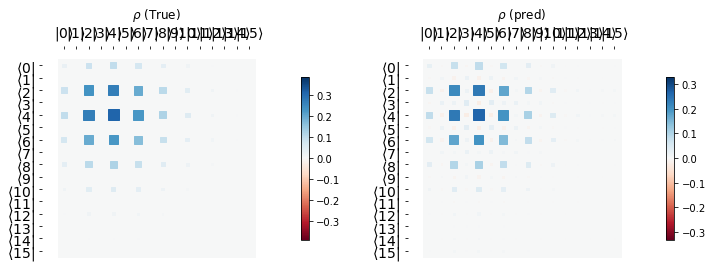

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

hinton(rho_true, ax=ax[0])
hinton(rho_predicted, ax=ax[1])
ax[0].set_title(r"$\rho$ (True)")
ax[1].set_title(r"$\rho$ (pred)")
plt.show()

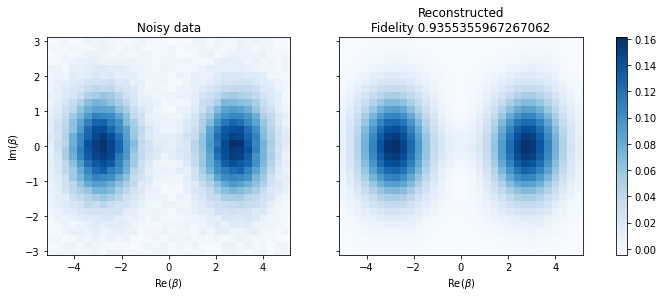

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

im = ax[0].pcolor(xvec, yvec, data.reshape((grid, grid)), cmap="Blues")
ax[1].pcolor(xvec, yvec, data_predicted.reshape((grid, grid)), cmap="Blues")

ax[0].set_xlabel(r"Re($\beta$)")
ax[1].set_xlabel(r"Re($\beta$)")
ax[0].set_ylabel(r"Im($\beta$)")
ax[0].set_title("Noisy data")
ax[1].set_title("Reconstructed\nFidelity {}".format(fidelity(rho_true, rho_predicted)))
plt.colorbar(im, ax=[axis for axis in ax])
plt.show()